In [166]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python


import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle  # import pickle, to read and save variables
import time
from mtcnn.mtcnn import MTCNN  # MTCNN, or Multi-Task Cascaded Convolutional Neural Networks
# Scikit learn
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils.fixes import loguniform
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, multilabel_confusion_matrix, matthews_corrcoef
from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r1, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [167]:
# Input data files are available in the read-only "../input/" directory

# If using kaggle:
base_file_path = "/kaggle/input/kul-h02a5a-computer-vision-ga1-2023/"
# For Thibeau: If using offline notebook:
base_file_path = "D:\Coding\Datasets\CV_GA1_data"

train = pd.read_csv(
    os.path.join(base_file_path, 'train_set.csv'), index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    os.path.join(base_file_path, 'test_set.csv'), index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'train/train_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(os.path.join(base_file_path, 'test/test_{}.npy').format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train), len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [168]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [169]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [170]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [ ]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7,cmap="Greys_r"):
    """Auxiliary function that plots a sequence of images in convenient format.

    Args:
        data (np.array): Sequence of images
        n (_type_): Number of images to plot
        imgs_per_row (int, optional): Number of images on each row. Defaults to 7.
        cmap (str, optional): Colormap used in plotting. Defaults to "Greys_r" for greyscale images.
    """
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i], cmap=cmap)
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i], cmap=cmap)
        else:
            ax[int(i%n)].imshow(data[i], cmap=cmap)
    plt.show()

### 0.3.1 HAAR face detector

The first preprocessor we try out is the HaarPreprocessor:

In [ ]:
def cut_out_face(img, x, y, width, height, factor = 0.1, center_x = None, center_y = None, square = True):
    
    # If we want the images to be square, adjust height or width (go for smallest square)
    if square:
        if width <= height:
            height = width
        else:
            width = height
            
    # In case a central point is provided, shift the coordinates to center that object
    if center_x is not None and center_y is not None:
        x = center_x - width/2
        y = center_y - height/2
    
    # Get the width and height of the image
    img_height, img_width = img.shape[0], img.shape[1]
    
    # Get new initial positions
    new_x = max(0, int(x - factor*width))
    new_y = max(0, int(y - factor*height*2))
    
    new_width  = min(img_width  - new_x, int((1 + 2*factor)*width))
    new_height = min(img_height - new_y, int((1 + 2*factor)*height))
    
    return img[new_y:new_y+new_height, new_x:new_x+new_width]

In [ ]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        # original HAAR img size
        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
        #return [cut_out_face(img, x, y, w, h) for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

Use the preprocessor on the train and test data

In [ ]:
haar_preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X_HAAR, train_y_HAAR = haar_preprocessor(train), train['class'].values
# test_X_HAAR                = haar_preprocessor(test)

Remove images that had no detection (negative pixel values)

In [ ]:
# Save the indices of the images with negative pixels (no detections)
indices_to_delete = []

# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X_HAAR):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"Deleting image {i} from training data")
        indices_to_delete.append(i)


# Save copy with (possibly) deleted false positives again data
train_X_HAAR = np.delete(train_X_HAAR, indices_to_delete, axis=0)
# remove corresponding class labels in train_y
train_y_HAAR = np.delete(train_y_HAAR, indices_to_delete, axis=0)

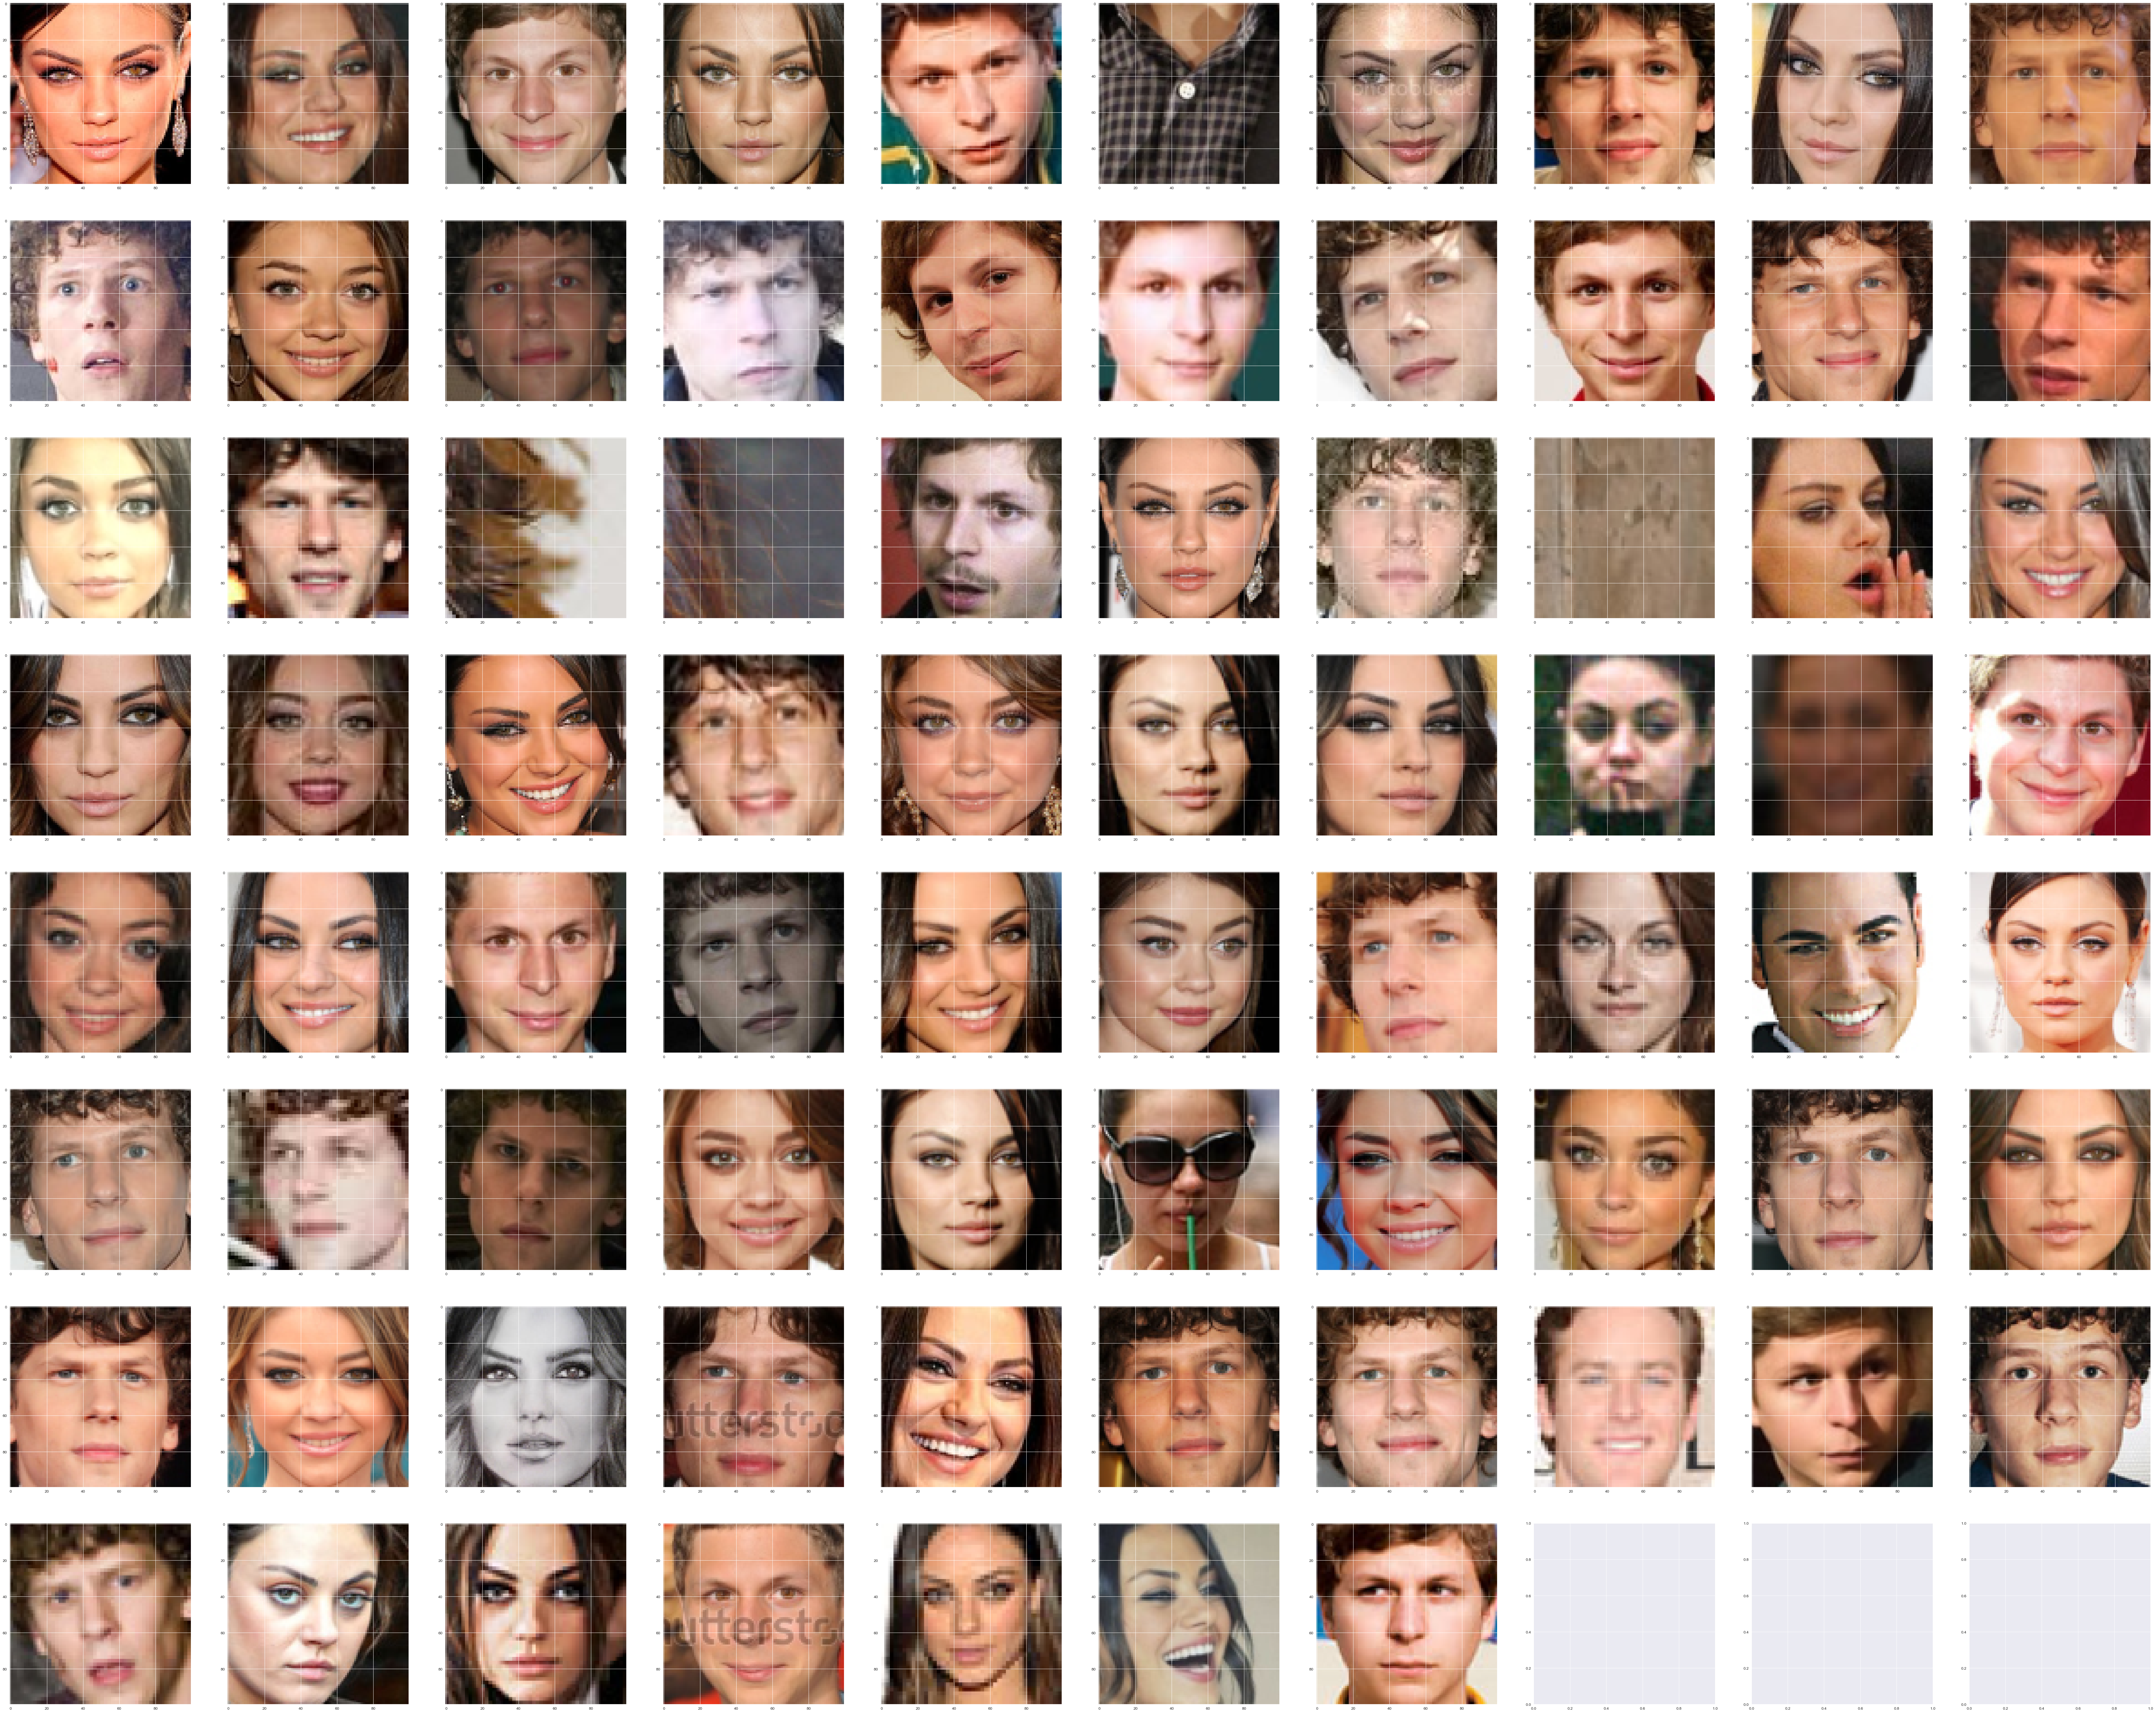

In [176]:
img_seq = train_X_HAAR
plot_image_sequence(img_seq, n=len(img_seq), imgs_per_row=10)

Remove false positives

In [177]:
# Remove images that aren't faces or aren't mila, jesse, michael, or sarah
indices_not_faces = [5, 22, 23, 27, 33, 38, 48, 58, 62, 67]
train_X_HAAR = np.delete(train_X_HAAR, indices_not_faces, axis=0)
train_y_HAAR = np.delete(train_y_HAAR, indices_not_faces, axis=0)

TODO there are still false positives here? What's wrong?

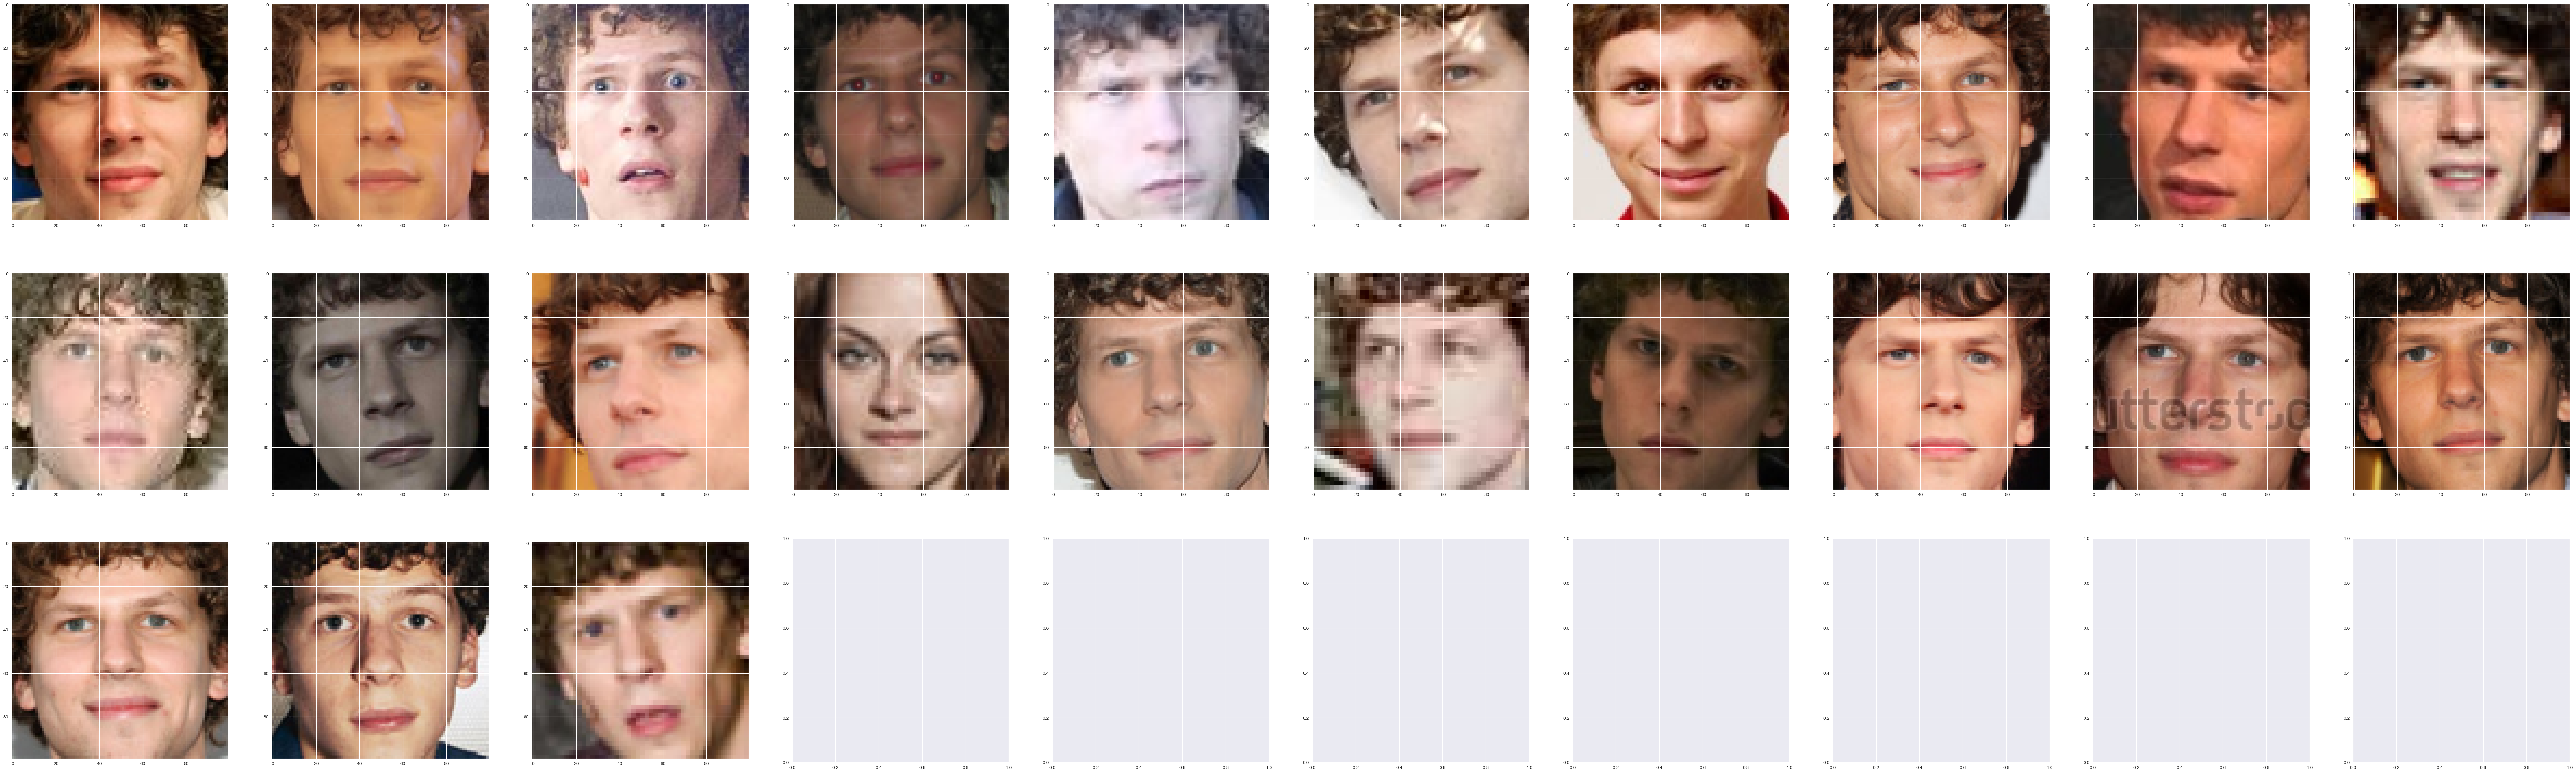

In [178]:
img_seq = train_X_HAAR[train_y_HAAR == 1]
plot_image_sequence(img_seq, n=len(img_seq), imgs_per_row=10)

### 0.3.2 MTCNN preprocessor

Now, use a different preprocessor. We look at MTCNN: see [this tutorial](https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/)

In [179]:
class MTCNNPreprocessor():
    """Preprocessing pipeline built around MTCNN."""
    
    def __init__(self, face_size, bbox_factor = 0.2):

        self.face_size = face_size
        self.detector = MTCNN()
        self.bbox_factor = bbox_factor

    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        # Make a copy, since MTCNN plots bounding boxes on top of our images
        return self.detector.detect_faces(img.copy())
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        # Detect the faces
        faces = self.detect_faces(img)
        # Boxes contain x, y, w, h of bounding box of each detected face
        boxes    = [face['box'] for face in faces]  
        # Nose key gives x and y
        noses = [face['keypoints']['nose'] for face in faces]
        
        # Extract faces
        extracted_faces = []
        for i in range(len(faces)):
            x, y, w, h = boxes[i]
            center_x, center_y = noses[i]
            cut_out = cut_out_face(img, x, y, w, h, factor = self.bbox_factor, center_x = center_x, center_y = center_y)
            extracted_faces.append(cut_out)
        
        return extracted_faces
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face, and resize
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

Define instance of MTCNN preprocessor

In [180]:
mtcnn_preprocessor = MTCNNPreprocessor(FACE_SIZE)

In [181]:
## Example output of detect_faces
# {'box': [62, 102, 170, 220],
#   'confidence': 0.9995554089546204,
#   'keypoints': {'left_eye': (102, 194),
#    'right_eye': (187, 191),
#    'nose': (145, 243),
#    'mouth_left': (112, 273),
#    'mouth_right': (183, 269)}},

Preprocess training data with MTCNN

In [182]:
%%capture
train_X_MTCNN, train_y_MTCNN = mtcnn_preprocessor(train), train['class'].values
# TODO - do it on test data as well
test_X_MTCNN           = mtcnn_preprocessor(test)# Also discard bad results, bad poses etc, which likely won't generalize well

### Remove bad results

indices_not_faces = [8, 28, 30, 40]
train_X_MTCNN = np.delete(train_X_MTCNN, indices_not_faces, axis=0)
train_y_MTCNN = np.delete(train_y_MTCNN, indices_not_faces, axis=0)

# Also discard non-detections
indices_to_delete = [] 

# Go over the training data, and delete images with negative pixel values
for i, img in enumerate(train_X_MTCNN):
    # Check if this image has any negative pixel value
    if np.any(img.flatten() < 0):
        print(f"Deleting image {i} from training data")
        indices_to_delete.append(i)
        

# Save copy with (possibly) deleted false positives again data 
train_X_MTCNN = np.delete(train_X_MTCNN, indices_to_delete, axis=0)
# remove corresponding class labels in train_y
train_y_MTCNN = np.delete(train_y_MTCNN, indices_to_delete, axis=0)

KeyboardInterrupt: 

In [183]:
img_seq = train_X_MTCNN
plot_image_sequence(img_seq, n=len(img_seq), imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

### 0.3.3 Choose data to work with

In [ ]:
train_X = train_X_MTCNN
train_y = train_y_MTCNN

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

# 1. Feature Representations
Feature extractors will be subclasses of a simple base class that implements the identity function:
$$
\forall x : f(x) = x.
$$


In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: Scale Invariant Feature Transform (SIFT)

SIFT is a method of feature extraction that is invariant to various transformations, such as scale, orientation, angle, etc. This makes it a promising method for face recognition as it can extract facial features specific to a person of interest from various images. A successful SIFT implementation is robust (same features are extracted from the same object in different conditions) and discriminative (different image objects can be easily separated from each other in feature space).

In this section we will implement SIFT using the opencv framework and demonstrate the advantages and disadvantages of these handcrafted features.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.utils.fixes import loguniform


class SIFTFeatureExtractor(IdentityFeatureExtractor):

    # initialize feature extractor
    def __init__(self, nFeatures, sigma, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10):
        self.nFeatures = nFeatures
        self.sigma = sigma
        self.allDescriptors = None
        self.allKeypoints = None
        self.sift = cv2.SIFT_create(nfeatures=nFeatures, sigma=sigma, nOctaveLayers=nOctaveLayers, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold)

    # get keypoints and feature descriptors for each image
    def detect_and_compute(self, images):
        all_descriptors = np.zeros((len(images),self.nFeatures, 128))
        all_keypoints = []
        # iterate over all images
        for i in range(len(images)):
            #normalize contrast
            im = np.array(images[i], dtype='uint8')
            # convert to grayscale
            gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            # apply bilateral filter to reduce noise
            filtered = cv2.bilateralFilter(gray, 3,150,150)
            # detectAndCompute returns keypoints and feature descriptors
            kp1, des1 = self.sift.detectAndCompute(filtered, None)
            (rows,columns) = des1.shape
            # maintain only nFeatures features for each image
            if rows>self.nFeatures:
                des1 = des1[0:self.nFeatures]
            all_descriptors[i] =np.array(des1)
            all_keypoints.append(np.array(kp1)[0:self.nFeatures])
        self.allKeypoints = all_keypoints
        self.allDescriptors = all_descriptors
        return all_descriptors, all_keypoints

    # return all matching features between two images
    def match(self, des1, des2):
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50) # or pass empty dictionary
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(np.float32(des1), np.float32(des2), k=2)
        return matches

    # draw the keypoints of an image
    def drawKeypoints(self, img, keypoints):
        image = np.zeros((100,100,3))
        image =cv2.drawKeypoints(img,keypoints,image)
        plt.imshow(image)

    # draw the matches between two images
    def drawMatches(self, im1, kp1, des1, im2, kp2, des2):
        matches = self.match(des1, des2)
        ratio_thresh = .85
        good_matches = []
        for m,n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append([m])
        im = cv2.drawMatchesKnn(im1, kp1, im2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig=plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        ax.imshow(im)
        plt.show()

    # filter out the poor matches between two images
    def getGoodFeatures(self, class_template, desc, kp):
        good_descriptors = []
        good_keypoints = []
        for i,des in enumerate(desc):
            matches = SIFTExtractor.match(class_template, des)
            # measure euclidian distance between two matches
            ratio_thresh = .85
            for m,n in matches:
                if m.distance < ratio_thresh * n.distance:
                    good_descriptors.append(des[m.queryIdx])
                    good_keypoints.append(kp[i][m.queryIdx])
        return good_descriptors, good_keypoints

### 1.1.1. Extracting Features
First we initialize our SIFT extractor with the parameters nFeatures=10 and sigma=.6.

Selecting a value of 10 for nFeatures allows our SIFT extractor to limit keypoints to discriminative features such as the contours of the eyes, nose, mouth.

The sigma parameter represents the sigma of the Gaussian that is applied to the image. Since our images have a weak quality and an additional bilateral filter is applied to each image before extracting features, we reduce this number.

These values (as well as the optional parameters contrastTreshold, edgeThreshold, nOctaveLayers) can be customized for various recognition tasks and depending on the quality of the input images.

In [ ]:
SIFTExtractor = SIFTFeatureExtractor(nFeatures=10, sigma=.6, nOctaveLayers = 3, contrastThreshold = .04, edgeThreshold=10)

As an example, the descriptors and keypoints are extracted from four images. The matches between these four images will be visualized in the following cells.

In [ ]:
# get keypoint and feature descriptors from each class of data
descriptors_mila, keypoints_mila = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==2])
descriptors_jesse, keypoints_jesse = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==1])
descriptors_michael_and_sarah, keypoints_michael_and_sarah = SIFTExtractor.detect_and_compute(train_X_HAAR[train_y_HAAR==0])

gray_jesse_1 = gray= cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==1][0]),cv2.COLOR_BGR2GRAY)
gray_jesse_2 = gray= cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==1][1]),cv2.COLOR_BGR2GRAY)
gray_michael_1 = gray= cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==0][0]),cv2.COLOR_BGR2GRAY)
gray_mila_1 = gray= cv2.cvtColor(np.uint8(train_X_HAAR[train_y_HAAR==2][0]),cv2.COLOR_BGR2GRAY)

Here we visualize the keypoints on an image of Jesse Eisenberg. Notably, we can see some distinct features extracted from the eyes, nostrils, and mouth edges.

In [ ]:
SIFTExtractor.drawKeypoints(gray_jesse_1, keypoints_jesse[0])

Let's visualize the features of two different images of Jesse Eisenberg. We see that the eye and nostril feature descriptors are robust as our SIFT extractor identifies them as matching features in both image representations. We do however see a false match between Jesse's mouth and nostril. This might be a result of the different lighting in each image. Normalizing the contrast in each image could help discriminate these features.

In [ ]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_jesse_2, keypoints_jesse[1], descriptors_jesse[1])

Now we visualize the features of Jesse Eisenberg and Mila Kunis. We see that no features are identified as matching between these two images. This suggests that the feature representations are discriminative as they are distinguishable between two different people.

In [ ]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_mila_1, keypoints_mila[0], descriptors_mila[0])

A true test of our feature recognition system is comparing the features of two 'lookalikes'. For this we visualize the features of Jesse Eisenberg and Michael Cera. The SIFT extractor falsely finds a match between the eye feature representation of these two images. This suggests that the feature descriptors are not local enough.

In [ ]:
SIFTExtractor.drawMatches(gray_jesse_1, keypoints_jesse[0], descriptors_jesse[0], gray_michael_1, keypoints_michael_and_sarah[0], descriptors_michael_and_sarah[0])

### 1.1.2. T-SNE Plot
T-SNE or t-Distributed Stochastic Neighbor Embedding is a method of visualizing high dimensional data in fewer dimensions.

Here we visualize the good descriptors of Jesse Eisenberg and Mila Kunis. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image. Similarity here is measured with euclidean distance.

In this section we will use the t-SNE framework from sklearn. We first initialize a TSNE object with the parameters n_components=2, perplexity=20, early_exaggeration=20 and the optional parameters learning_rate='auto', init='random', n_iter=2000.

We choose 2 for the number of components because it more intuitive for visualization purposes. Perplexity is generally a value between 5 and 50 that represents the balance between local and global features in our feature space. We choose 50 for this value as we estimate 50 near neighbors in each class. A value of 20 is chosen for early_exaggeration to accentuate the distance between classes.

We can see that the features for Jesse and Mila form two distinct classes. However, the distance between these two classes is not very big. This is expected as the feature representations for facial features may be similar even from person to person.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Get the 'good' descriptors of all images of mila and jesse. A descriptor is deemed good if it is similar to other descriptors in the same locality of the image where similarity is measured with euclidean distance.
good_mila_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_mila[0], descriptors_mila, keypoints_mila)
good_jesse_descriptors, _ = SIFTExtractor.getGoodFeatures(descriptors_jesse[0], descriptors_jesse, keypoints_jesse)

# plot the tsne
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50, n_iter=2000, verbose=1, early_exaggeration=20)
z_jesse = tsne.fit_transform(np.array(good_jesse_descriptors))
z_mila = tsne.fit_transform(np.array(good_mila_descriptors))

sns.scatterplot(x=z_jesse[:,0], y=z_jesse[:,1], label='jesse')
sns.scatterplot(x=z_mila[:,0], y=z_mila[:,1], label='mila')
plt.show()

### 1.1.3. Discussion
robust and discriminative
how local should the descriptors be
how o tmake desscriptors sbehave well in different circumstances (lightitng>)
visualize w tsne
how does sthissi efature compare w previouss grabbing task in inidividual assignmentt
any preprocessing?

## 1.2. Baseline 2: PCA feature extractor

__Principal Component Analysis__ (PCA) is a technique used to extract highly variant components (set of points) from data. In our case, we will apply it to faces in order to extract those components that make up the variability of the faces. Ideally, we would discretize or isolate components containing facial features that can be later used to discriminate the faces in our dataset. Most of the work in applying this method relies in picking informative components and the least amount of background noise as well as aligning the faces to a reference point to reduce variance generated only based on the location of the face.

For PCA, we first convert each image in our training set into a one-dimensional array by flattening the images. If color images are used, we flatten each color channel and concatenate them. For simplicity, we discuss the case of performing PCA on square grasycale images, each having the same size $K\times K$ (with, by default, $100\times 100$ for our training set). After flattening, we hence have a matrix $M$, often called the __data matrix__ of size $Z \times K^2$, with $Z$ the number of training examples. The columns (flattened pixels) then represent random variables, while the rows indicate different samples of those random variables. In our case, the matrix hence has size $80 \times 10 \ 000$. Given this data matrix, we zero-mean the dataset. That is, we compute the mean of each column and subtract it from all training examples. This ensures good performance of PCA, as we discard information contained in the mean of the dataset, which is not very informative.  

There are then two ways to proceed with PCA. The first option is to compute the covariance matrix of this data matrix $M$. This will give a covariance matrix $C$ of size $K^2 \times K^2$, of which we compute the eigenvalue decomposition (EVD). The principal components are then determined by the largest eigenvalues and their corresponding eigenvectors of this covariance matrix, since they indicate the directions of highest variance. By keeping $q$ principal components, we compute a projection matrix of size $q \times K^2$ which stores the corresponding eigenvectors as columns. Given a flattened image $x$ with shape $K^2 \times 1$, we can compute a lower-dimensional representation $z = W\cdot x$, and $z$ is often referred to as the __feature vector__. The time complexity of computing the EVD on a $n\times n$ matrix is $\mathcal{O}(n^3)$.

The other approach is to use **singular value decomposition** (SVD). It generalizes the concept of eigenvalue decomposition, which can only be applied to square matrices, to matrices of any shape. Similar to the EVD case, here we keep the $q$ largest singular values and their corresponding vectors as the principal components. The time complexity of computing the SVD on a $m\times n$ matrix is $\mathcal{O}\left( \text{min}\left( mn^2, m^2 n \right) \right)$.

In our case, the matrix of interest has shape $80 \times 10 \ 000$. Due to this dimensionality, computing the SVD of this matrix is much more efficient than the SVD. During our experiments, we noted that computing the EVD on the covariance matrix could easily take more than 10 minutes, whereas the SVD takes only a few seconds. We did not see any significant advantage for the EVD in terms of performance. As such, we decided to stick to the SVD in this implementation. Our implementation makes use of scikit-learn's PCA, which in turn calls numpy's SVD optimised function.

One challenge with PCA is choosing the number of principal components. One way to choose this value is by looking at the eigenvalues/singular values $\lambda_i$, $i = 1, ..., N$ of the data matrix, ordered in decreasing magnitude. (For EVD, $N$ equals $K^2$, while for SVD, $N$ equals $Z$). We can then decide the number of principal components $q$ by requiring that these components explain a certain percentage $p$ of the variance in the dataset, *i.e.* choose $q$ such that
\begin{equation}  
    \frac{\sum_{i=1}^q \lambda_i}{\sum_{i=1}^N \lambda_i} \geq p \, .
\end{equation}  
Another approach could be to investigate the average reconstruction loss on the training images. In the end, the number of principal components is another hyperparameter of the classifier, and one needs to carefully tune this hyperparameter, such as via a knee plot. 


TODO: still include: Mean subtraction or not? yes, commonalities on all the faces are not informative!! entropy is minimal => information gain is minimal

In [ ]:
from sklearn.decomposition import PCA
# We use a scikit function to rescale pixel values to the (0, 255) range
from skimage.exposure import rescale_intensity

In [ ]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """
    PCA feature extractor which, given training data, finds the ideal set of principal components. Inspired by assignment 3 of the artificial neural networks course.
    """
    
    def __init__(self, n_components=20, use_color=False):
        """Initialization.

        Args:
            n_components (int/float, optional): Number of components to keep. Either an integer or a float. When a float, this is the percentage
            of the total variance that has to be explained by the principal components. Defaults to 20.
            use_color (bool, optional): Whether to use all color channels for PCA, or to work with grayscale images. Defaults to True.
        """

        self.n_components = n_components
        # ^ the number of principal components to be computed
        self.model = None
        # ^ the PCA model, will be initialized in fit
        self.meanface = None
        # ^ the mean of all the input training data
        self.use_color = use_color
        # ^ whether we train PCA on color images or on grayscale images

        # We will save the original shape of the input data for convenience, used inside this class
        self.width     = None
        self.height    = None
        self.shape     = None

    def preprocess_data(self, X):
        """Preprocess the images, such as converting to grayscale and flattening.

        Args:
            X (np.array): Data matrix containing several images of the same shape.

        Returns:
            None: no return
        """
        # Save the original shape for later on
        self.shape = X.shape[1:]
        
        # In case we use grayscale, drop color channels
        if not self.use_color:
            self.shape = self.shape[:-1]
        self.width, self.height = self.shape[0], self.shape[1]

        if self.use_color:
            self.data_matrix = np.array([img.flatten() for img in X])
        else:
            # Convert images to grayscale
            X_gray = np.mean(X, axis=3)
            # Flatten images
            self.data_matrix = np.array([img.flatten() for img in X_gray])

    def fit(self, X):
        """Fit the PCA on the training data.

        Args:
            X (np.array): The training data, consisting of several images of the same shape.
        """
        self.model = PCA(self.n_components, svd_solver="full", whiten=True)
        self.preprocess_data(X)
        self.model.fit(self.data_matrix)
        # Also save the mean face as a 2D image, in color or grayscale
        self.meanface = rescale_intensity(self.model.mean_.reshape(self.shape), out_range=(0, 255)).astype(np.uint8)
        # Save the eigenfaces for convenience of plotting later on:
        self.eigenfaces = np.array([rescale_intensity(face.reshape(self.shape), out_range=(0, 255)).astype(np.uint8) for face in self.model.components_])

    def transform(self, X):
        """Compute feature vector of the given sequence of images according to the fitted PCA, i.e. project on principal components.
        NOTE has to be an array of images, so for a single image, put it in an array of one element

        Args:
            X (np.array): Sequence of images to be converted to their latent/feature representation.

        Returns:
            np.array: Features of the sequence of provided images.
        """
        
        # Simply call the transform of scikit-learn's PCA, but reshape the matrix in desired shape
        X = np.array([img.flatten() for img in X])

        return self.model.transform(X)

    def inverse_transform(self, X):
        """Reconstruct images (i.e. convert back to their original shape) based on their latent feature representation.
        NOTE has to be an array of images, so for a single image, put it in an array of one element
        Args:
            X (np.array): Feature representation of the images.

        Returns:
            np.array: Reconstructed images.
        """
        X = np.array([img.flatten() for img in X])

        # Go from the latent space back to original space
        reconstructed = self.model.inverse_transform(X)
        # Reshape back into a 2D image (works for both color or gray)
        reconstructed = np.array([img.reshape(self.shape) for img in reconstructed])
        # Normalize the values:
        reconstructed = rescale_intensity(reconstructed, out_range=(0, 255)).astype(np.uint8)

        return reconstructed 

In [ ]:
pca = PCAFeatureExtractor()
# Fit the PCA
pca.fit(train_X)

### 1.2.1. Eigenface Plots

Plot the mean face

In [ ]:
plt.imshow(pca.meanface, cmap="Greys_r")
plt.title("Mean face from training data")
plt.show()

Plot examples of the eigenfaces (not all shown here)

In [ ]:
# Choose how many eigenfaces to plot (please, a multiple of two)
nb_eigenfaces_to_show = pca.n_components
nb_per_row = 10
plot_image_sequence(pca.eigenfaces[0:nb_eigenfaces_to_show], n=nb_eigenfaces_to_show, imgs_per_row=nb_per_row)

### 1.2.2. Feature Space Plots

We show a single reconstruction of a single test face, the third image in the train dataset.

In [ ]:
example_face = train_X[2]
if not pca.use_color:
    example_face = np.mean(example_face, axis=2)

# Show image, possibly in grayscale if desired
plt.imshow(example_face.reshape(pca.shape), cmap="Greys_r")
plt.show()

Do reconstruction (transformation & inverse transformation):

In [ ]:
reduced = pca.transform([example_face])
reconstructed = pca.inverse_transform([reduced])[0]
# Show reconstructed face:
plt.imshow(reconstructed, cmap="Greys_r")
plt.show()

Now, do this for various principal components. 

In [ ]:
reconstructed_images = []
max_nb_components = 50
nb_per_row = 10

for nb_of_components in range(max_nb_components):
    # Set number of principal components and recompute the projection matrix
    pca.n_components = nb_of_components+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed = pca.inverse_transform(pca.transform([example_face]))
    reconstructed_images.append(np.copy(reconstructed)[0])

plot_image_sequence(reconstructed_images, n=max_nb_components, imgs_per_row=nb_per_row, cmap="Greys_r")

Have some way to compute error:

In [ ]:
def rmsd(x, y):
    """
    Computes root mean square deviation between two arrays.
    """

    return np.sqrt(np.mean((x - y)**2))

In [ ]:
errors = []
max_nb_components = 50

# Check whether we train with grayscale or color images
if pca.use_color:
    original_data = train_X
else:
    # If we use grayscale, convert all the training images to grayscale as well
    original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])

for i in range(max_nb_components):
    # Set number of principal components and recompute the projection matrix
    pca.n_components = i+1
    pca.fit(train_X)
    # Compute the reconstruction
    reconstructed_faces = pca.inverse_transform(pca.transform(original_data))
    # reconstructed_faces = np.array([pca.inverse_transform(pca.transform([train_face])) for train_face in original_data])
    error = np.mean([rmsd(original_data, reconstructed_faces)])
    # Append to list, make sure to reshap
    errors.append(error)

plt.plot([i+1 for i in range(len(errors))], errors, '-o', color='red')
plt.ylabel("RMSD")
plt.xlabel("Number of components")
plt.grid()
plt.show()

#### Face-feature plots

In [ ]:
pca.n_components = 2
pca.fit(train_X)

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
delta_image = 0.25
delta_plot = 0.5
latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

for i in range(train_X.shape[0]):
    image = train_X[i]
    latent = latent_reps[i]
    ax.imshow(image, interpolation='nearest', extent=(latent[0]-delta_image, latent[0]+delta_image, latent[1]-delta_image, latent[1]+delta_image), zorder=100)
# Make image clean
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Faces plotted in PCA space')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

Similar plots, but show the classes instead

In [ ]:
fig = plt.figure(figsize = (10,10))
delta_image = 0.5
delta_plot = 0.5
latent_reps = np.array([pca.transform([image]).flatten() for image in original_data])

colors = ["black", "red", "blue"]

for i in range(original_data.shape[0]):
    image = original_data[i]
    latent = latent_reps[i]
    plt.scatter(latent[0], latent[1], color = colors[train_y[i]])

# Make image clean
plt.xlim(latent_reps[:, 0].min()-delta_plot, latent_reps[:, 0].max()+delta_plot)
plt.ylim(latent_reps[:, 1].min()-delta_plot, latent_reps[:, 1].max()+delta_plot)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Class labels plotted in PCA space')
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.grid()
plt.show()

### 1.2.3. Discussion

Attempt to choose an optimal number p of principal components such that the dimensionality
of the feature space is reduced but still informative (e.g. based on the average reconstruction
loss of your training images). 
Reflect on your choice of p and how this might have influenced the performance of the features that you learned. Did you need specifc pre-processing steps before computing these
feature descriptors on your images (which ones and why)? How many non-zero eigenvalues did you have, why is this? Did the visualisation show good discriminative and robustness properties?

*answer all of these, maybe in different paragraphs*

# 2. Evaluation Metrics


# 3. Classifiers
## 3.0. Example: The random classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier

For SVM, see [this tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html).

In [ ]:
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import time

In [ ]:
n_components = 50
pca = PCAFeatureExtractor(n_components = n_components)
pca.fit(train_X)

In [ ]:
# Get the PCA representation of train and test data
if pca.use_color:
    original_data = train_X
else:
    # If we use grayscale, convert all the training images to grayscale as well
    original_data = np.array([np.mean(train_face, axis=2) for train_face in train_X])
train_X_pca = pca.transform(original_data)

In [ ]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(
    train_X_pca, train_y, test_size=0.25, random_state=42
)

# Now search for best params for SVC

param_grid = {
    "C": loguniform(1e-1, 1e5),
    "gamma": loguniform(1e-7, 1e2),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
)
start = time.time()
clf = clf.fit(X_train, y_train)
end = time.time()
print("done in %0.3fs" % (end - start))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

In [ ]:
pred_y = clf.predict(X_test)

print(classification_report(y_test, pred_y))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""

    def __init__(self):

        self.model = None

    
    def fit(self, X, y):
        # Now search for best params for SVC

        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500
        )
        clf = clf.fit(X_train, y_train)
        print(clf.best_estimator_)

        # Save the best model
        self.model = clf.best_estimator_


    def predict(self, X):
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

### 3.2 SIFT Classifier

In [ ]:
class SIFTClassifier:

    def __init__(self, k):
        self.k = k
        self.hist = None
        self.clp = None
        self.kmeans = None

    # flatten descriptors to two dimensions
    def flatten(self, arr):
        all_descriptors = []
        for img_descriptors in arr:
            # get each feature from image
            for descriptor in img_descriptors:
                all_descriptors.append(descriptor)
        all_descriptors = np.stack(all_descriptors)
        return all_descriptors

    # fit datat with mini batch k means
    def fit(self, desc):
        flattened_desc = self.flatten(desc)
        kmeans = MiniBatchKMeans(n_clusters=self.k, batch_size=20).fit(flattened_desc)
        self.kmeans = kmeans

    # cluster data into histograms based on prediction
    def histogram(self, all_kp, all_desc):
        hist = []
        for i in range(len(all_desc)):
            hist_i = np.zeros(self.k)
            nkp = np.size(all_kp[i])

            for d in all_desc[i]:
                idx = self.kmeans.predict([d])
                hist_i[idx] +=1/nkp
            hist.append(hist_i)
        self.hist = hist
        return hist

    # train classifier
    def train(self, train_hist, train_y):
        param_grid = {
            "C": loguniform(1e-1, 1e5),
            "gamma": loguniform(1e-7, 1e2),
        }
        clf = RandomizedSearchCV(
            SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=500)
        start = time.time()
        clf = clf.fit(np.array(train_hist), train_y)
        end = time.time()
        print("done in %0.3fs" % (end - start))
        print("Best estimator found by grid search:")
        print(clf.best_estimator_)
        self.clf = clf
        return clf

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

classifier = SIFTClassifier(10)

# split training data
X_train, X_test, y_train, y_test = train_test_split(
    train_X_HAAR, train_y_HAAR, test_size=0.25, random_state=42
)

# get descriptors and keypoints of train data
train_des, train_kp = SIFTExtractor.detect_and_compute(X_train)
classifier.fit(train_des)
# cluster training points by their keypoints
train_hist = classifier.histogram(train_kp, train_des)
# train
clf = classifier.train(train_hist, y_train)

# get desscriptors and keypoints of test data
test_des, test_kp = SIFTExtractor.detect_and_compute(X_test)
# cluster test data by keypoints
test_hist = classifier.histogram(test_kp, test_des)
# predict
pred_y = classifier.clf.predict(test_hist)

print(classification_report(y_test, pred_y))

## 3.1. Baseline 2: Transfer learning CNN

In [ ]:
# Import keras VGG and fine tune layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
from keras.optimizers import Adam
import keras.callbacks


class VGG16FeatureExtractorAndClassifier:
    """TODO: under construction."""

    def __init__(self):
        # Load
        vgg = VGG16(include_top=False, input_shape=FACE_SIZE + (3,))

        vgg.trainable = False

        for layer in vgg.layers:
            if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3']:
                layer.trainable = True

        # Modify top layers to classify 4 classes
        flatten = Flatten()(vgg.layers[-1].output)
        classifier = Dense(128, activation='relu')(flatten)
        output_prob = Dense(4, activation='softmax')(classifier)

        # Save modified
        self.model = Model(inputs=vgg.inputs, outputs=output_prob)

    def fit(self, X, y):
        X_train = vgg16_preprocess_input(X)

        # Compile model
        self.model.compile(run_eagerly=True, optimizer=Adam(
            learning_rate=0.00002), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                "best_model", save_best_only=True, monitor='val_sparse_categorical_accuracy', save_format='tf',
            ),
            keras.callbacks.EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                restore_best_weights=True,
                patience=20,
            )
        ]

        # Fit model
        self.model.fit(X_train, y, epochs=100,
                       batch_size=64, validation_split=0.2, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(vgg16_preprocess_input(X))

    def __call__(self, X):
        return self.predict(X)


In [ ]:
vgg_fe_cls = VGG16FeatureExtractorAndClassifier()
vgg_fe_cls.model.summary()

In [ ]:
vgg_fe_cls.fit(train_X, train_y)

In [ ]:
test_y_probs = vgg_fe_cls.predict(test_X_HAAR) # TODO: change test_X_HAAR for the best test set! or hand label, idk

# disable numpy scientific notation
np.set_printoptions(suppress=True)

test_y_probs

In [ ]:
test_y_star = np.argmax(test_y_probs, axis=1)
test_y_star

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

__NOTE__ this is very basic and brute force code as test

In [ ]:
feature_extractor = PCAFeatureExtractor(n_components=n_components, use_color=False)
feature_extractor.fit(train_X)
classifier = FavoriteClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(original_data), train_y)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(original_data)

"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

In [ ]:
# predict the labels for the test set 
test_y_star = model(test_X)

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
